In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import patchworklib as pw

from py_helper_functions import *

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

from patsy.highlevel import dmatrices

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso

In [115]:
def get_cleaned_data(src: str) -> pd.DataFrame:
    '''
    This function takes a path to a csv file, cleans it and returns the cleaned dataframe
    :param src: path to file
    :return: dataframe with cleaned data
    '''
    df = pd.read_csv(src)
    
    # Filter the data for:
    #
    working_sample = df[['id','name','host_id','host_name','host_since','host_is_superhost','host_listings_count','host_total_listings_count','host_has_profile_pic','host_identity_verified','neighbourhood_cleansed','property_type','room_type','accommodates','bathrooms_text','beds','price','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','reviews_per_month']][(df['price'].notna()) 
                        & (df['beds'].notna())
                        & (df['host_is_superhost'].notna())
                        & (df['bathrooms_text'].notna())
                        & (df['accommodates'] <= 6) & (df['accommodates'] >= 2)
                        & (work_df.f_neighbourhood_cleansed.isin(['Palermo', 'Catania', 'Gravina di Catania', 'San Gregorio di Catania', 'Militello in Val di Catania', 'Messina', 'Taormina', 'Realmonte', 'Agrigento', 'Siracusa', 'Cefal', 'Monreale', 'Ragusa', 'Modica']))]
    
    # add boolean variables from text columns
    working_sample['d_host_is_superhost'] = working_sample['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_host_has_profile_pic'] = working_sample['host_has_profile_pic'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_host_identity_verified'] = working_sample['host_identity_verified'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_instant_bookable'] = working_sample['instant_bookable'].apply(lambda x: 1 if x == 't' else 0)
    
    # calculate host time
    working_sample['n_host_since'] = working_sample['host_since'].apply(lambda x: (pd.Timestamp('2024-02-02') - pd.Timestamp(x)).days)
    
    # convert price to numerical
    working_sample['price'] = working_sample['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))
    
    # filter for price < 
    working_sample = working_sample[(working_sample['price'] <= 400)]
    
    # fill NA data for reviews with 0s
    working_sample.fillna(0, inplace=True)
    
    # add numerical variable for number of bath
    working_sample['n_bathrooms'] = working_sample['bathrooms_text'].apply(lambda x: 0.5 if 'half-bath' in x.lower() else float(x.lower().split()[0]))
    
    # rename numerical and categorical columns to have prefix
    working_sample.rename(columns={
        # 'host_listings_count': 'n_host_listings_count',
        # 'host_total_listings_count': 'n_host_total_listings_count',
        'accommodates': 'n_accommodates',
        'beds': 'n_beds',
        'minimum_nights': 'n_minimum_nights',
        'maximum_nights': 'n_maximum_nights',
        # new apartment not on market so no need to care about reviews
        # 'number_of_reviews': 'n_number_of_reviews',
        # 'reviews_per_month': 'n_reviews_per_month',
        # 'review_scores_rating': 'n_review_scores_rating',
        # 'review_scores_accuracy': 'n_review_scores_accuracy',
        # 'review_scores_cleanliness': 'n_review_scores_cleanliness',
        # 'review_scores_checkin': 'n_review_scores_checkin',
        # 'review_scores_communication': 'n_review_scores_communication',
        # 'review_scores_location': 'n_review_scores_location',
        # 'review_scores_value': 'n_review_scores_value',
        'neighbourhood_cleansed': 'f_neighbourhood_cleansed',
        'property_type': 'f_property_type',
        'room_type': 'f_room_type'
    }, inplace=True)
    
    del df
    
    return working_sample

In [116]:
work_df = get_cleaned_data('listings.csv')
# test_df = get_cleaned_data('https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment2/listings.csv')
work_df.shape

(17689, 35)

In [117]:
work_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17689 entries, 1 to 56682
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           17689 non-null  int64  
 1   name                         17689 non-null  object 
 2   host_id                      17689 non-null  int64  
 3   host_name                    17689 non-null  object 
 4   host_since                   17689 non-null  object 
 5   host_is_superhost            17689 non-null  object 
 6   host_listings_count          17689 non-null  int64  
 7   host_total_listings_count    17689 non-null  int64  
 8   host_has_profile_pic         17689 non-null  object 
 9   host_identity_verified       17689 non-null  object 
 10  f_neighbourhood_cleansed     17689 non-null  object 
 11  f_property_type              17689 non-null  object 
 12  f_room_type                  17689 non-null  object 
 13  n_accommodates       

In [118]:
work_df.head()

,id,name,host_id,host_name,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,d_host_is_superhost,d_host_has_profile_pic,d_host_identity_verified,d_instant_bookable,n_host_since,n_bathrooms
1,22948,Bed and breakfast in Agrigento · ★4.80 · 1 bed...,88837,Giuseppe,2010-03-05,t,3,5,t,t,...,4.89,4.85,f,2.46,1,1,1,0,5082,1.0
7,44672,Condo in Syracuse · ★4.81 · 1 bedroom · 1 bed ...,196573,Francesco,2010-08-09,t,2,4,t,t,...,4.96,4.77,f,1.01,1,1,1,0,4925,1.0
8,89175,Bed and breakfast in Taormina · ★4.88 · 1 bedr...,486101,Giuseppe Alfonso,2011-04-05,t,2,3,t,t,...,4.93,4.82,f,2.28,1,1,1,0,4686,1.0
10,45304,Rental unit in Agrigento · ★4.71 · 1 bedroom ·...,200638,Antonio,2010-08-13,f,1,1,t,t,...,4.66,4.72,f,3.19,0,1,1,0,4921,1.0
14,46486,Rental unit in Syracuse · 1 bedroom · 1 bed · ...,207959,La Frescura,2010-08-21,f,2,4,t,f,...,0.00,0.00,f,0.00,0,1,0,0,4913,1.0


In [119]:
work_df.price.describe(percentiles=[.25, .5, .75, .99])

count    17689.000000
mean        92.755441
std         56.095051
min         11.000000
25%         58.000000
50%         78.000000
75%        109.000000
99%        320.000000
max        400.000000
Name: price, dtype: float64

<Axes: xlabel='price', ylabel='Percent'>

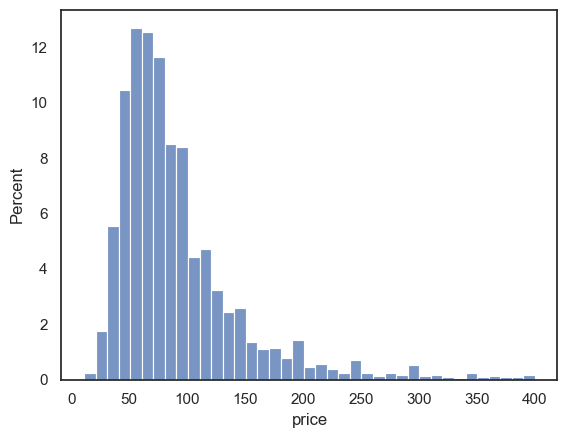

In [120]:
sns.set(style="white")
sns.histplot(
    data = work_df,
    x = 'price', stat='percent', binwidth=10)

In [121]:
categorical_columns = [col for col in work_df.columns if col.startswith("f_")]
numerical_columns = [col for col in work_df.columns if col.startswith("n_") or col.startswith("d_")]

In [122]:
# build interaction terms
interactions = ['f_property_type*f_room_type',
                'n_accommodates*f_property_type',
                'n_accommodates*f_room_type',
                'f_property_type*f_neighbourhood_cleansed',
                'f_room_type*f_neighbourhood_cleansed',
                'n_accommodates*f_neighbourhood_cleansed'
                ]

In [123]:
categorical_columns

['f_neighbourhood_cleansed', 'f_property_type', 'f_room_type']

In [124]:
numerical_columns

['n_accommodates',
 'n_beds',
 'n_minimum_nights',
 'n_maximum_nights',
 'd_host_is_superhost',
 'd_host_has_profile_pic',
 'd_host_identity_verified',
 'd_instant_bookable',
 'n_host_since',
 'n_bathrooms']

In [125]:
data_train, data_holdout = train_test_split(work_df, train_size=0.7, random_state=42)
data_train.shape, data_holdout.shape

((12382, 35), (5307, 35))

In [163]:
# LASSO for OLS
y, X = dmatrices('price~' + '+'.join(numerical_columns) + '+' + '+'.join(categorical_columns) + '+' + '+'.join(interactions), data_train)
ols_terms_list = X.design_info.column_names
X

DesignMatrix with shape (12382, 1288)
  Columns:
    ['Intercept',
     'f_neighbourhood_cleansed[T.Catania]',
     'f_neighbourhood_cleansed[T.Cefal]',
     'f_neighbourhood_cleansed[T.Gravina di Catania]',
     'f_neighbourhood_cleansed[T.Messina]',
     'f_neighbourhood_cleansed[T.Militello in Val di Catania]',
     'f_neighbourhood_cleansed[T.Modica]',
     'f_neighbourhood_cleansed[T.Monreale]',
     'f_neighbourhood_cleansed[T.Palermo]',
     'f_neighbourhood_cleansed[T.Ragusa]',
     'f_neighbourhood_cleansed[T.Realmonte]',
     'f_neighbourhood_cleansed[T.San Gregorio di Catania]',
     'f_neighbourhood_cleansed[T.Siracusa]',
     'f_neighbourhood_cleansed[T.Taormina]',
     'f_property_type[T.Boat]',
     'f_property_type[T.Camper/RV]',
     'f_property_type[T.Casa particular]',
     'f_property_type[T.Cave]',
     'f_property_type[T.Dammuso]',
     'f_property_type[T.Dome]',
     'f_property_type[T.Earthen home]',
     'f_property_type[T.Entire bed and breakfast]',
     'f_pr

In [138]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
# define grid
grid = dict()
grid["alpha"] = np.arange(0.05, 1, 0.05)
# define search
ols_search = GridSearchCV(model, grid, scoring="neg_root_mean_squared_error", cv=cv)
# perform the search
ols_results = ols_search.fit(X, y)

In [139]:
ols_results.best_estimator_

Lasso(alpha=0.4)

In [140]:
ols_results.cv_results_

{'mean_fit_time': array([1.86293969, 0.80859118, 0.84793429, 0.78526506, 0.73812547,
        0.73206272, 0.71793232, 0.64350929, 0.60575476, 0.54414883,
        0.54248319, 0.53701015, 0.55325832, 0.53515553, 0.54838157,
        0.54828153, 0.54142261, 0.52342601, 0.48508229]),
 'std_fit_time': array([0.16764851, 0.09698395, 0.15803719, 0.11389345, 0.14212899,
        0.10415273, 0.09501132, 0.07143019, 0.05137902, 0.05317637,
        0.05789761, 0.06762735, 0.07625758, 0.04419823, 0.0599039 ,
        0.06779276, 0.06176356, 0.07114989, 0.059048  ]),
 'mean_score_time': array([0.05550218, 0.05543399, 0.0179492 , 0.04263339, 0.09013319,
        0.03157687, 0.02490692, 0.04617748, 0.04930763, 0.04249263,
        0.0662653 , 0.04208465, 0.02125473, 0.062637  , 0.0262362 ,
        0.02297702, 0.03609543, 0.05191689, 0.05808072]),
 'std_score_time': array([0.04531765, 0.0340238 , 0.01271126, 0.02714896, 0.08252128,
        0.01516057, 0.00671021, 0.03711616, 0.0256801 , 0.04373548,
        

In [141]:
df_ols_results = pd.DataFrame(ols_results.cv_results_)[['param_alpha', 'rank_test_score', 'mean_test_score']]
df_ols_results

,param_alpha,rank_test_score,mean_test_score
0,0.05,19,-49.545364
1,0.1,18,-49.408944
2,0.15,13,-49.317945
3,0.2,9,-49.261412
4,0.25,7,-49.232631
5,0.3,5,-49.214129
6,0.35,2,-49.201545
7,0.4,1,-49.198617
8,0.45,3,-49.203319
9,0.5,4,-49.211978


In [171]:
ols_term_coef = pd.DataFrame(ols_results.best_estimator_.coef_, index=ols_terms_list)
ols_term_coef[(ols_term_coef.iloc[:, 0] != 0)]

,0
f_neighbourhood_cleansed[T.Catania],-0.655091
f_neighbourhood_cleansed[T.Cefal],2.915026
f_neighbourhood_cleansed[T.Siracusa],0.523931
f_neighbourhood_cleansed[T.Taormina],8.288192
f_property_type[T.Boat],0.769684
...,...
d_host_is_superhost,-0.498617
d_host_identity_verified,-0.079694
d_instant_bookable,2.390129
n_host_since,0.207584


In [ ]:
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

rfr = RandomForestRegressor(random_state = 20240202)

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)